# analysis: adjusted rand between schema and subject response 
* model "parity rule" predicts subjects will respond left to one schema and right to another schema
    * this makes a prediction about the errors we should expect
* to test this, we can look at the adjusted rand value between schema and subject response
    * according to this logic, we expect subjects who failed in the interleaved ahve high adjusted rand
    
# notebook organization
* first we checked the adjusted rand for each subject
    * we realized most subjects in both conditions had close to zero adjRand
* then we checked whether subjects develop this suprious relationship for a small period of time
    * to do this we rand windowed adjusted rand
* finally we checked for significance with a bootstrat null 
    * both at subject and at group levels

In [1]:
import os, re
import pandas as pd
import numpy as np
import json

from sklearn.metrics import adjusted_rand_score

from glob import glob as glob


from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline
plt.rcParams['font.size'] = 22

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from csw2022 import *

# load relevant dataframes
### need to pull out subjects response node to compare with schema

In [3]:
def load_interleaved_dfs(thresh=THRESHOLD):
  """ load interleaved conditions and 
  include information about `tonode response` in dataframes
  NB 
  """

  dfL = []
  for cidx in range(2):
    condition = ['interleaved','interleaved_rep'][cidx]
    
    _df = load_final_df(condition,thresh)

    ## find right node and left node
    for i,d in _df.iterrows():
      # if true on right, right_node = true_tonode
      _df.loc[i,'right_state'] = node2stateD[
        [d.true_tonode,d.false_tonode][int(d.true_on_right)]
      ]
      _df.loc[i,'left_state'] = node2stateD[
        [d.true_tonode,d.false_tonode][np.abs(1-int(d.true_on_right))]
      ]

    ## find response node
    for i,df_row in _df.iterrows():
      _df.loc[i,'response_state'] = [df_row.left_state,df_row.right_state][int(df_row.response_right)]

    ## schema index
    _df.loc[:,'schema_idx'] = (_df.true_rfc.str.split('_').str[-1].str.split('-').str[1] == 'jungle').astype(int)
    dfL.append(_df)
  ##
  df_i,df_ir = dfL
  return df_i,df_ir



In [4]:
df_i,df_ir = load_interleaved_dfs()
dfD = {'interleaved':df_i,'interleaved_rep':df_ir}


-loading code version: RT01B1000cl
N = 55 subjects

-loading code version: csw1000block01.04.25.19
N = 56 subjects


In [5]:
## subject numbers above threshold
subnumsD = {
  'interleaved': df_i.index.get_level_values('subjnum').unique().values,
  'interleaved_rep':df_ir.index.get_level_values('subjnum').unique().values
}
for i in subnumsD.values():
  print(len(i) )
  print(subnumsD.values())

39
dict_values([array([ 1,  3,  5,  8,  9, 11, 12, 13, 16, 20, 21, 23, 24, 25, 27, 28, 29,
       30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48,
       49, 50, 51, 53, 54]), array([ 1,  2,  4,  5,  6,  9, 10, 13, 14, 15, 17, 19, 21, 26, 27, 34, 40,
       42, 44, 48, 49, 52, 54, 55])])
24
dict_values([array([ 1,  3,  5,  8,  9, 11, 12, 13, 16, 20, 21, 23, 24, 25, 27, 28, 29,
       30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48,
       49, 50, 51, 53, 54]), array([ 1,  2,  4,  5,  6,  9, 10, 13, 14, 15, 17, 19, 21, 26, 27, 34, 40,
       42, 44, 48, 49, 52, 54, 55])])


# adjusted rand for each subject across entire experiment

In [6]:
def adjusted_rand(dfD):
  D = {}
  for condstr, df in dfD.items():
    adjrandL = []
    for idx, sub_df in df.groupby('subjnum'):
      ## compute adjusted rand (only for 3/4=>5/6)
      sub_df = sub_df[sub_df.index.get_level_values('depth')==1]
      ## adjusted rand (schema, subject responses)
      sub_ar = adjusted_rand_score(
        sub_df.response_state.values,
        sub_df.schema_idx.values
      )
      adjrandL.append(sub_ar)
    D[condstr] = adjrandL
  return D

adjrandD = adjusted_rand(dfD)

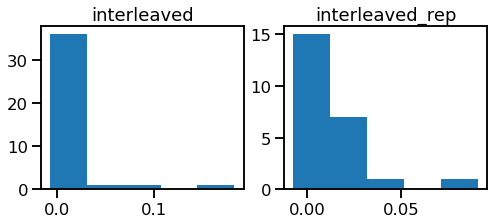

In [7]:
fg,axar = plt.subplots(1,2,figsize=(8,3))
for ax,(condstr_,adjrand) in zip(axar,adjrandD.items()) :
  ## plot
  ax.hist(adjrand,bins=5)
  ax.set_title(condstr_)
#   plt.savefig('figures/interleaved-adjrand')

# moving window adjusted rand

In [8]:
def windowed_adjusted_rand(X,Y,window):
  assert len(X)==len(Y)
  AR = -np.ones(len(X)-window)
  for wi in range(len(X)-window):
    AR[wi] = adjusted_rand_score(
      X[wi:wi+window],
      Y[wi:wi+window]
    )
  return AR

In [9]:
def compute_subj_windowed_adjrand(df,window):
  """ compute war on all subjects in df
  returns list (subj) of list (time) because 
  different subjects have different number of timepoints
  """
  subnums = df.index.get_level_values('subjnum').unique()
  Nsubs = subnums.shape[0]
  warLoL = []
  for idx,(sidx,sub_df) in enumerate(df[df.index.get_level_values('depth')==1].groupby(['subjnum'])):
    sub_win_ar = windowed_adjusted_rand(
      sub_df.response_state.values,
      sub_df.schema_idx.values,
      window
    )
    warLoL.append(sub_win_ar)
  return warLoL

## compute windowed adjrand on both dfs
# warD = {c:compute_subj_windowed_adjrand(d,20) for c,d in dfD.items()}
# len(warD['interleaved']),len(warD['interleaved'][0])

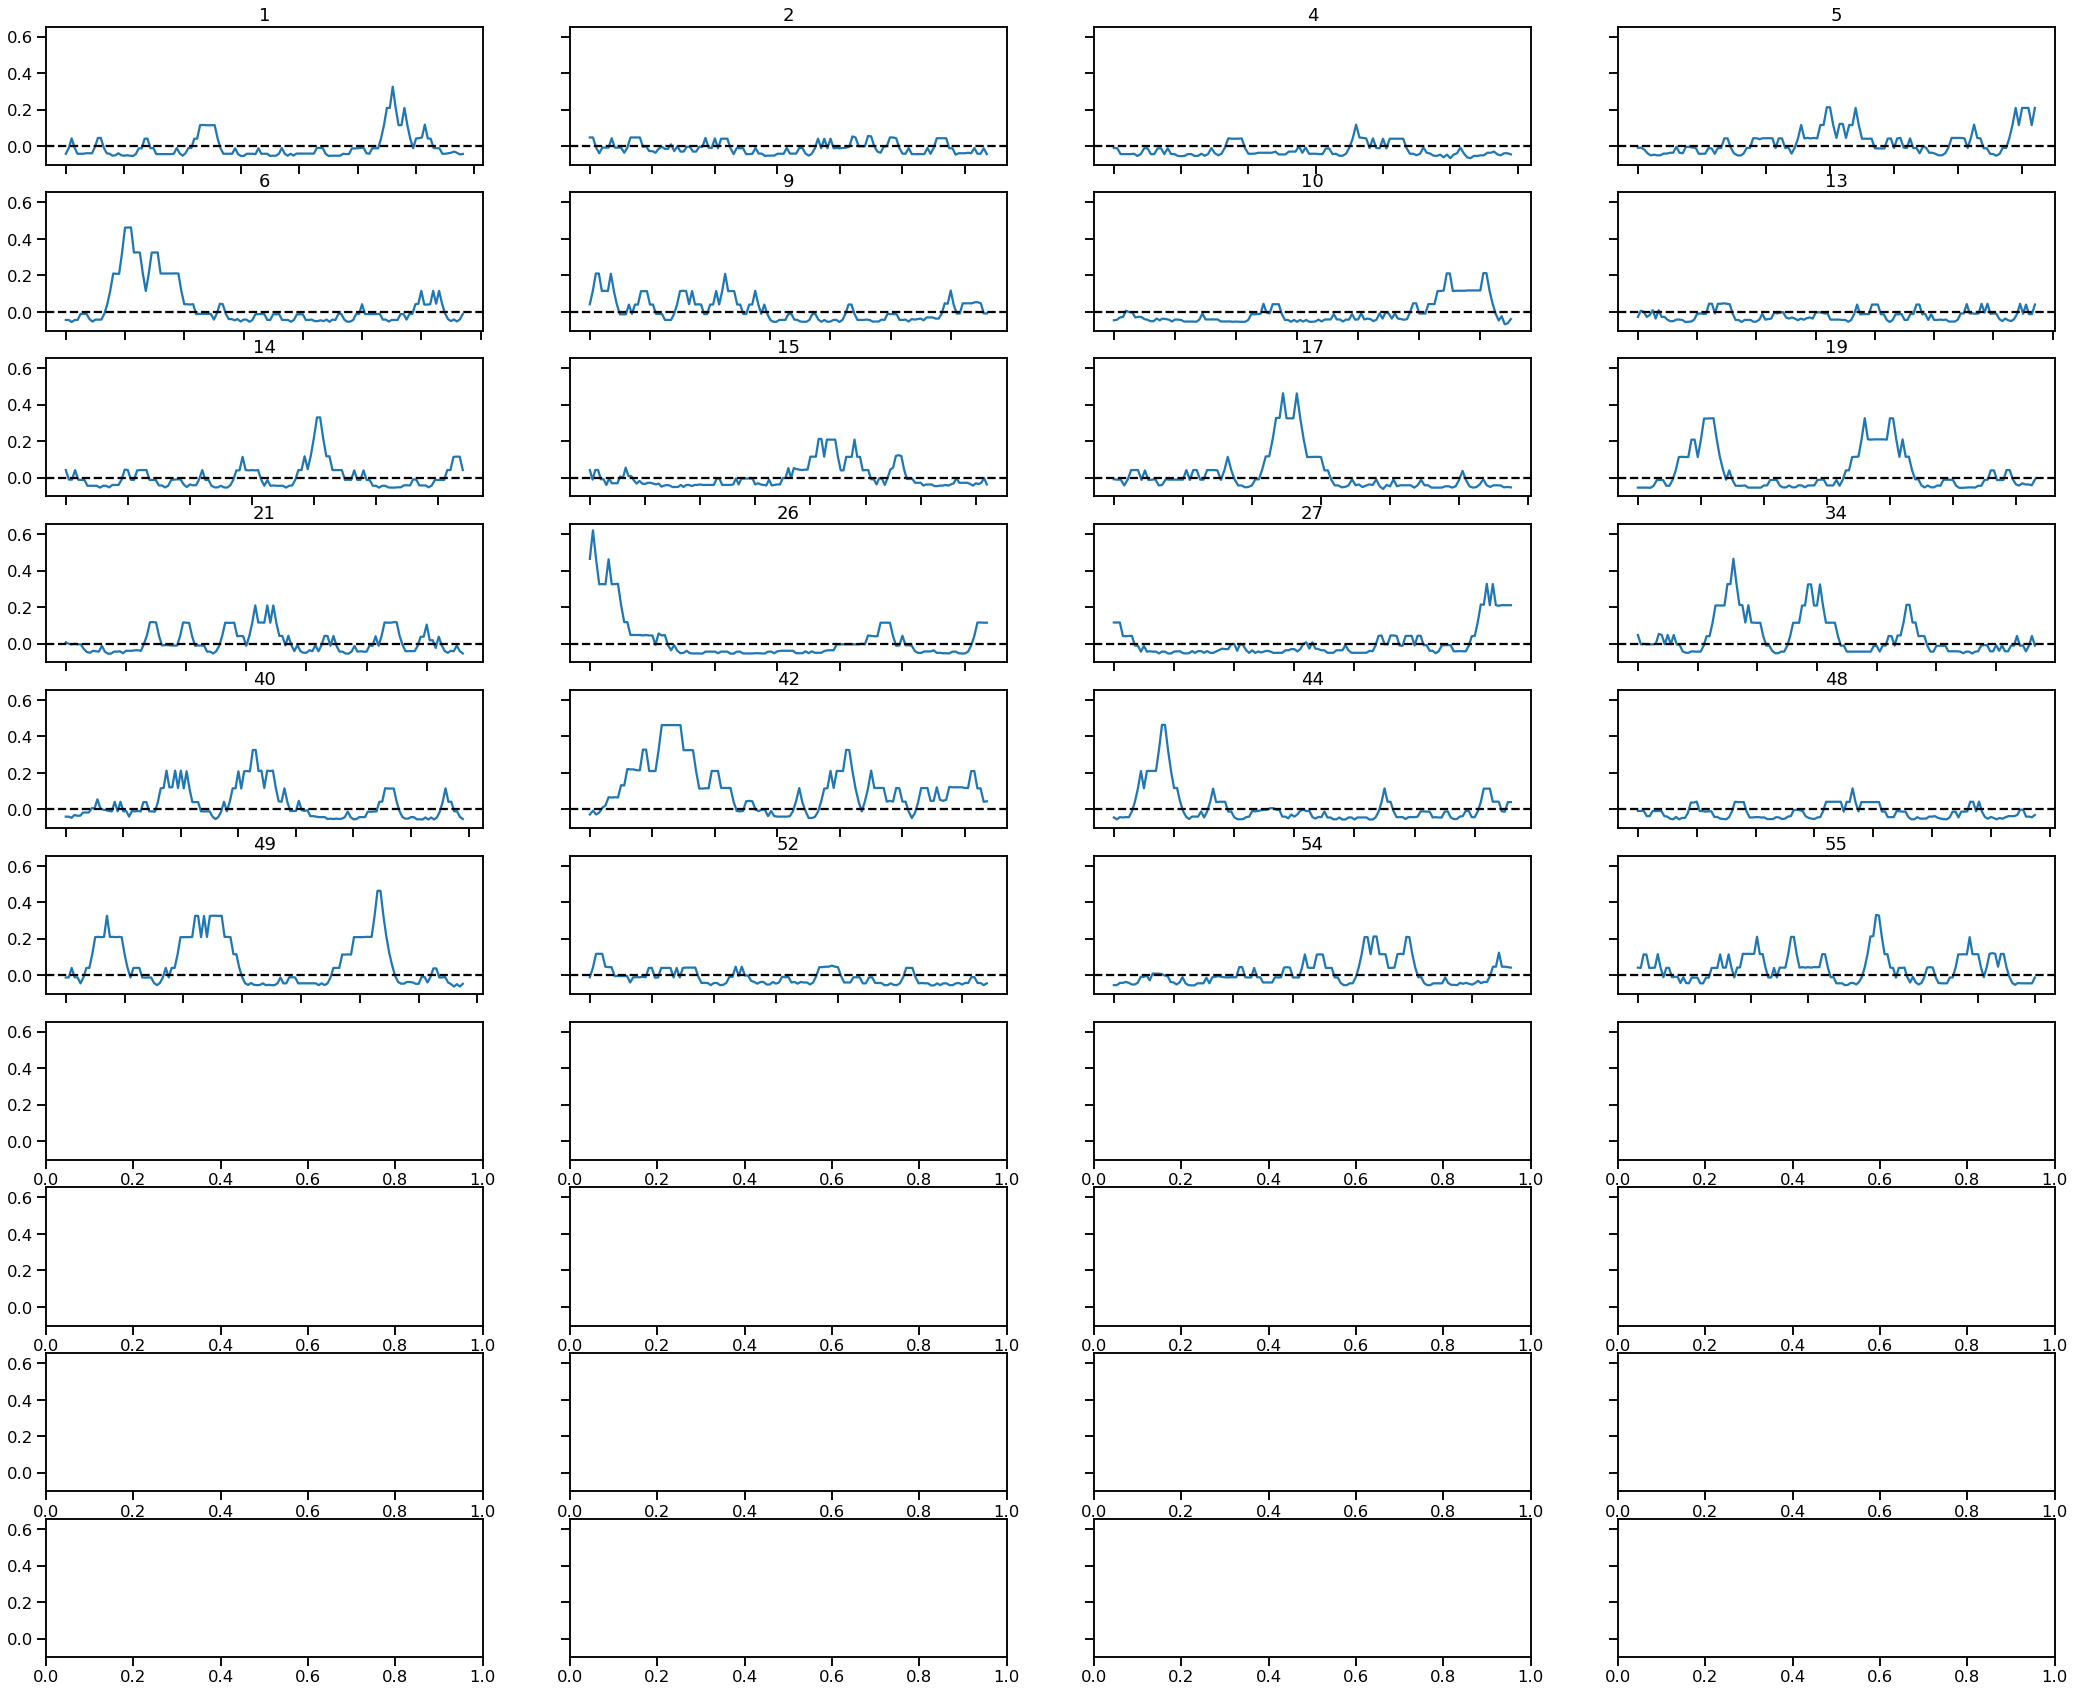

In [10]:
window_ = 20
for cstr,df_ in dfD.items():
  subnums = df_.index.get_level_values('subjnum').unique()
  warLOL = compute_subj_windowed_adjrand(df_,window_)
  ## plot
  plt.close('all')
  fig,axarr = plt.subplots(10,4,figsize=(36,30),sharey=True);axarr=axarr.reshape(-1)
  for idx,(subj_idx,subj_war) in enumerate(zip(subnums,warLOL)):
    ax=axarr[idx]
    ax.set_title(subnums[idx])
    ax.plot(subj_war)
    ax.axhline(0,c='k',ls='--')
    ax.set_xticklabels([])
  plt.savefig('figures/interleaved_adjrand/subj_war/%s-window_%i'%(cstr,window_))
  

## windowed adjsted rand with bootstrap null

In [11]:
def run_war_analysis(sub_df,window,nitr_null):
  """ 
  computes windowed adjusted rand on subject
  also returns null distribution 
  """
  ## only do the analysis on tstep 1
  sub_df[sub_df.index.get_level_values('depth')==1]
  # subject war 
  sub_war = windowed_adjusted_rand(
    sub_df.response_state.values,
    sub_df.schema_idx.values,
    window
  )
  ## null distribution
  sub_exp_len = sub_df.shape[0]
  null_sub_resp = np.random.choice([2,3],[nitr_null,sub_exp_len])
  null_sub_war = -np.ones([nitr_null,sub_exp_len-window])
  ## multiple iterations per subject
  for itr in range(nitr_null):
    null_sub_war[itr] = windowed_adjusted_rand(
      sub_df.schema_idx.values,
      null_sub_resp[itr],
      window=window
    )
  assert len(sub_war)==len(null_sub_war[0])
  return sub_war,null_sub_war
  

In [12]:
# ## this cell takes a while to run
# savedir = 'analysis_data/window_adjrand/'

# windw = 18
# nitr_null = 100
# for cstr,group_df in dfD.items():
#   print(cstr)
#   for sub_idx,sub_df in group_df.groupby('subjnum'):
#     sub_war,sub_null_war = run_war_analysis(sub_df,windw,nitr_null)
#     np.save(
#       savedir+'s%.2i-war-window_%i-%s'%(sub_idx,windw,cstr),
#       sub_war
#     )
#     np.save(
#       savedir+'s%.2i-null_war-window_%i-%s'%(sub_idx,windw,cstr),
#       sub_null_war
#     )

In [13]:
def load_sub_war(condition,sub_idx,window):
  savedir = 'analysis_data/window_adjrand/'
  sub_war = np.load(
    savedir+'s%.2i-war-window_%i-%s.npy'%(
      sub_idx,window,condition)
  )
  sub_null_war = np.load(
    savedir+'s%.2i-null_war-window_%i-%s.npy'%(
      sub_idx,window,condition)
  )
  return sub_war,sub_null_war

[len(i) for i in load_sub_war('interleaved',sub_idx=1,window=18)]

[283, 100]

# thresholding war

In [14]:
def war_metric(sub_war,null_sub_war,threshold=0.05):
  """ 
  sub_war: 1d array [exp_len-window] subject windowed ar
  null_sub_war: 2d array [itr,exp_len-window], nitr nulls for sub
  returns: sub_metric, metric_null_distr
  """
  sub_metric = np.sum(sub_war>threshold)
  null_distr_metric = np.sum(null_sub_war>threshold,1)
  return sub_metric,null_distr_metric

# war_metric(sub_war,sub_null_war)

In [15]:
## return test acc per subject
df_testacc = lambda df_: df_[df_.index.get_level_values('block')==4].groupby('subjnum').correct_response.mean()

def get_df_accthresh(df,min_testacc):
  """ returns df of subjects with `testacc > min_testacc`
  """
  ## subjects with test accuracy greater than min_testacc
  subnums = df_testacc(df)[df_testacc(df)>min_testacc].index.values
  resul_df = pd.concat([sd for si,sd in df.groupby(['subjnum']) if si in subnums])
  return resul_df

def get_subnums_accthresh(df,min_testacc):
  subnums_above = df_testacc(df)[df_testacc(df)>min_testacc].index.values
  subnums_below = df_testacc(df)[df_testacc(df)<=min_testacc].index.values
  return subnums_above,subnums_below

# df.groupby(['subjnum','block']).correct_response.mean()
for ta in np.arange(0.5,1.0,0.05):
  subs_above,subs_below = get_subnums_accthresh(df_ir,ta)
  print(
    'testacc >',ta.round(2),
    '\n subs',subs_above
  )

testacc > 0.5 
 subs [ 2  4  5  6 10 13 14 15 17 26 27 34 42 48 49 52 54 55]
testacc > 0.55 
 subs [ 2  5  6 10 14 15 17 26 27 48 49 52 54 55]
testacc > 0.6 
 subs [ 2  5  6 10 15 17 26 27 49 55]
testacc > 0.65 
 subs [ 2  5  6 10 15 26 27 49 55]
testacc > 0.7 
 subs [ 2  5  6 15 26 49 55]
testacc > 0.75 
 subs [ 2  5  6 26 49 55]
testacc > 0.8 
 subs [ 2  5  6 26 49 55]
testacc > 0.85 
 subs [ 2  5  6 26 49 55]
testacc > 0.9 
 subs [ 2  5  6 26]
testacc > 0.95 
 subs [ 2  6 26]


In [16]:
testacc_thresh = 0.7
war_thresh = 0.1
adjrand_window = 18


warscoreD = {}
subnumD = {}
for cstr,cdf in dfD.items():
  print(cstr)
  ## get subject numbers above and below testacc threshold
  subs_above,subs_below = get_subnums_accthresh(cdf,testacc_thresh)
  subnumD['%s-above'%cstr] = subs_above
  subnumD['%s-below'%cstr] = subs_below
  print(len(subs_above),'above',len(subs_below),'below')
  print('above',subs_above)
  print('below',subs_below)
  for gidx in range(2):
    groupstr = cstr + ['-aboveM','-belowM'][gidx]
    subsnums = [subs_above,subs_below][gidx]
    ## loop over subnum
    subwarL = []
    subwarnullL = []
    for sidx in subsnums:
      ## load sub war and null war
      sub_war,sub_null_war = load_sub_war(cstr,sub_idx=sidx,window=adjrand_window)
      ## calc warscore
      sub_war_score,sub_null_war_score = war_metric(sub_war,sub_null_war,war_thresh)
      ## aggregate
      subwarL.append(sub_war_score)
      subwarnullL.append(sub_null_war_score)
    warscoreD[groupstr] = [np.array(subwarL),np.array(subwarnullL)]

interleaved
7 above 32 below
above [ 5  8 11 23 27 28 44]
below [ 1  3  9 12 13 16 20 21 24 25 29 30 31 32 34 35 36 37 38 39 40 41 42 43
 45 47 48 49 50 51 53 54]
interleaved_rep
7 above 17 below
above [ 2  5  6 15 26 49 55]
below [ 1  4  9 10 13 14 17 19 21 27 34 40 42 44 48 52 54]


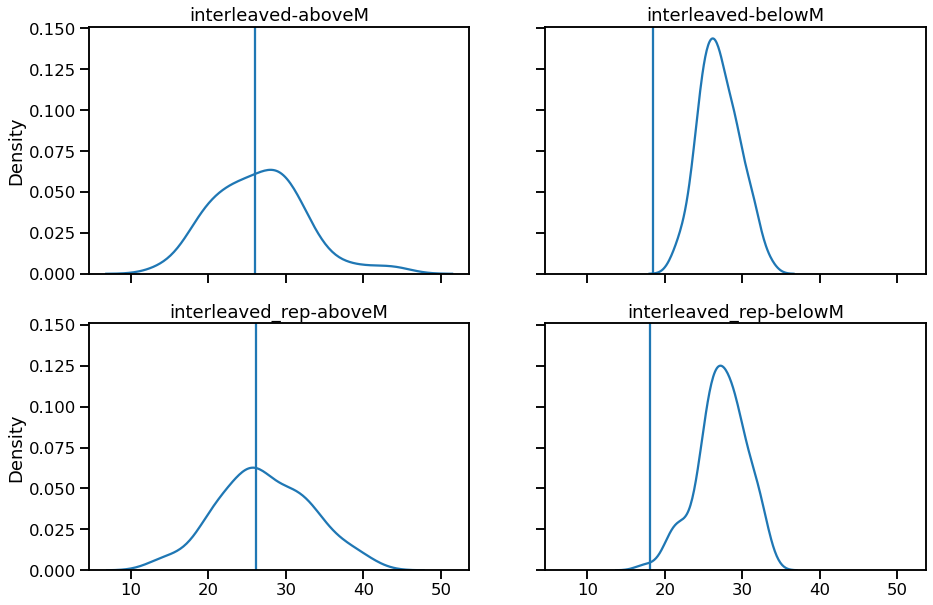

In [17]:
fg,axar = plt.subplots(2,2,figsize=(15,10),sharey=True,sharex=True);axar=axar.reshape(-1)
for ax,(grstr,(war,warnull)) in zip(axar,warscoreD.items()):
  sns.kdeplot(warnull.mean(0),ax=ax)
  ax.axvline(war.mean(0))
  ax.set_title(grstr)
plt.savefig('figures/interleaved_adjrand/kde-window_adj_rand_score')

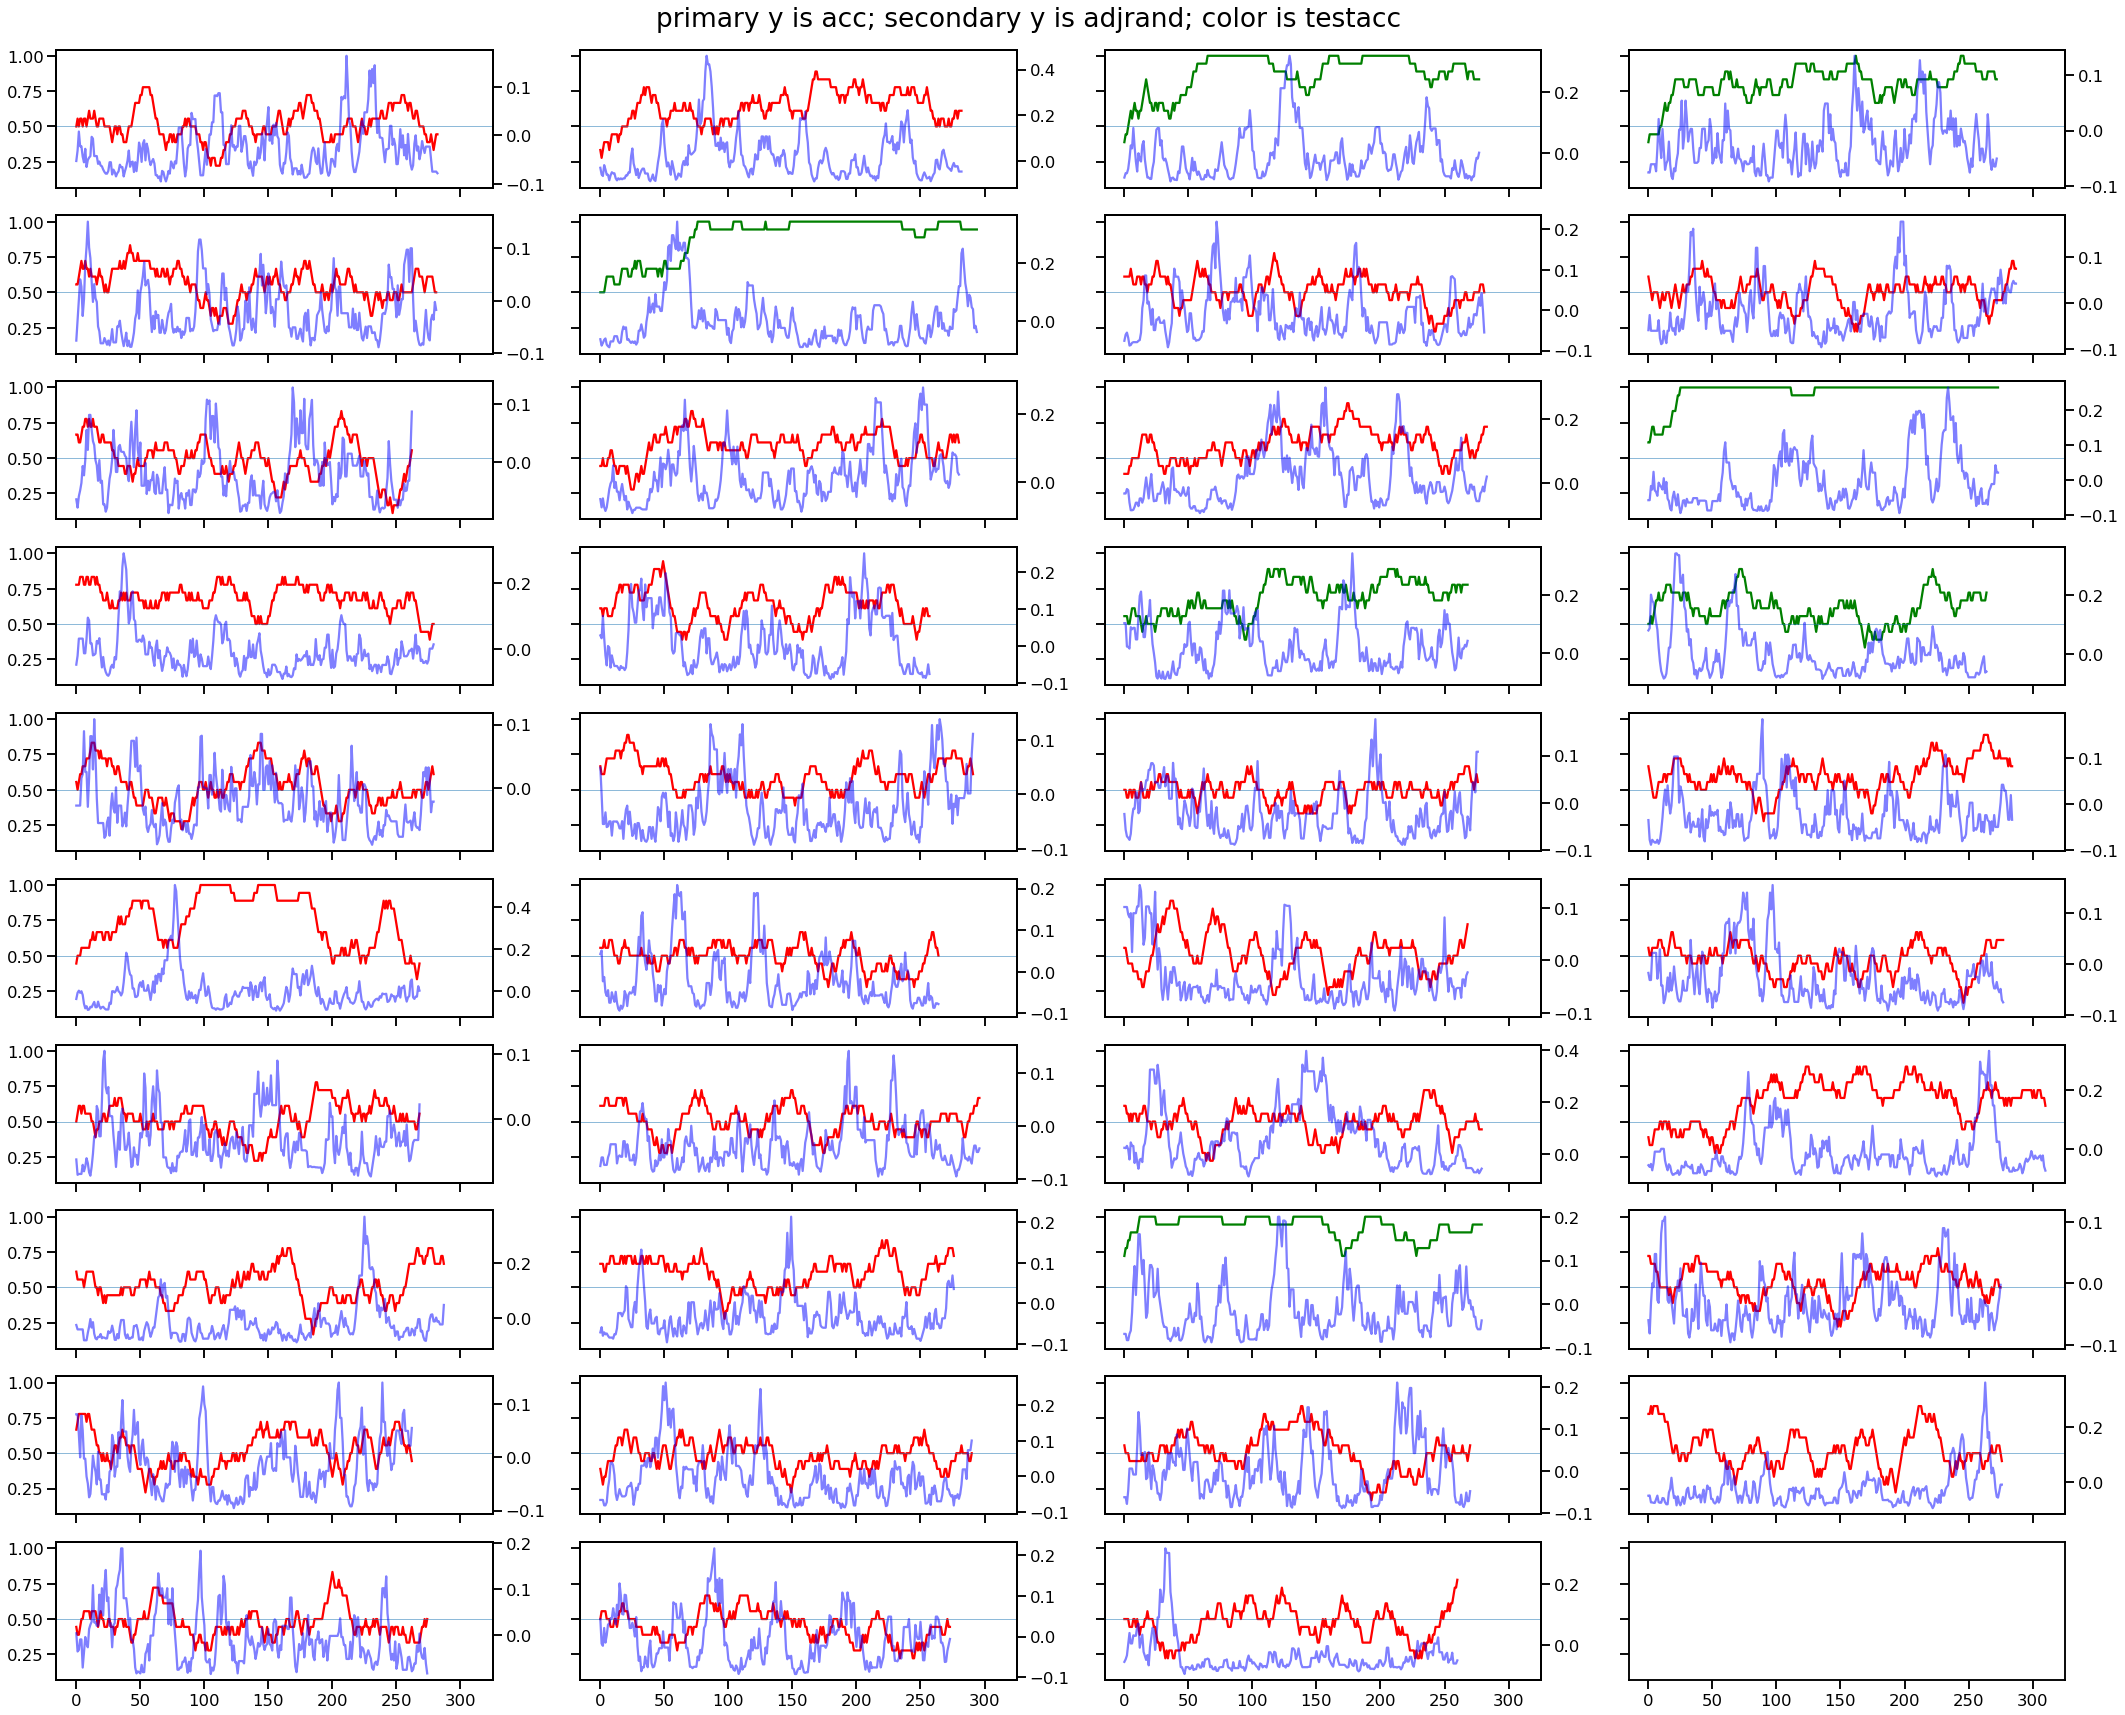

In [18]:
cond = 'interleaved'
df_ = dfD[cond]
fig,axar = plt.subplots(10,4,figsize=(36,30),sharey=True,sharex=True);axar=axar.reshape(-1)

for ix,(sub_idx,sub_df) in enumerate(df_.groupby(['subjnum'])):
  if sub_idx in subnumD['%s-above'%cond]:
    c='g'
  elif sub_idx in subnumD['%s-below'%cond]:
    c='r'
  else: 
    continue
  sub_war,_ = load_sub_war(cond,sub_idx,18)
  sub_acc = mov_avg(sub_df.correct_response.values,18)
  
  ## plot
  ax=axar[ix]
  ax.plot(sub_acc,c=c)
  ax.axhline(0.5,lw=0.5)
  ax2 = ax.twinx()
  ax2.plot(sub_war,c='b',alpha=0.5)


plt.suptitle('primary y is acc; secondary y is adjrand; color is testacc',y=.9)
plt.savefig('figures/interleaved_adjrand/%s-sub_acc_vs_adjrand'%cond)

  